In [1]:
import sys
sys.path.append('.\\')

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# RNN
from keras.models import Sequential  
from keras.layers import Dense, GRU
from keras.layers import Input

import helper_functions

# Extract data

In [9]:
train_data = helper_functions.load_data()

In [18]:
# Data is normalised, so each input has the same shape
input_shape = train_data["mfccs"][0].shape
print(f'mel-log data shape: {input_shape}')

mel-log data shape: (15, 173)


In [19]:
n_classes = len(train_data['classes'][0])
n_classes

12

In [11]:
x = np.array(train_data['mfccs'])
y = np.array([helper_functions.one_hot_to_label(label) for label in train_data['classes']])
y_train_one_hot = np.array(train_data['classes'])

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y_train_one_hot, test_size=0.2)
n_dim = x_train.shape[2]

In [13]:
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.4)

In [99]:
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'n_dim: {n_dim}')

x_train shape: (51776, 15, 173)
y_train shape: (51776, 12)
n_dim: 173


# Build the model

In [25]:
from keras.layers import GlobalMaxPooling1D, Dropout, BatchNormalization
from keras.optimizers import Adam

In [93]:
model = Sequential()
model.add(Input(shape=input_shape))
model.add(BatchNormalization(axis=2))
model.add(GRU(n_dim*2, return_sequences=True, dropout=0.01, recurrent_dropout=0.1, activation='relu'))  
model.add(GRU(n_dim, dropout=0.05, recurrent_dropout=0.15, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling1D(input_shape=(None, 15, 173)))
# model.add(GRU(n_dim, return_sequences=True, dropout=0.1, recurrent_dropout=0.2, activation='relu'))  
# model.add(Dropout(0.2))
# model.add(GRU(n_dim, dropout=0.1, recurrent_dropout=0.2))  
# model.add(Dense(15, activation='relu'))  
model.add(Dense(n_classes, activation='softmax'))

In [94]:
# model compilation  
from keras.metrics import FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall
optimizer = Adam(learning_rate=1e-3)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', FalsePositives(), FalseNegatives(), TruePositives(), TrueNegatives(), Precision(), Recall()])

In [95]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 15, 173)           692       
_________________________________________________________________
gru_6 (GRU)                  (None, 15, 346)           540798    
_________________________________________________________________
gru_7 (GRU)                  (None, 15, 173)           270399    
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 173)           0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 173)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                2088      
Total params: 813,977
Trainable params: 813,631
Non-trainable params: 346
______________________________________________

In [96]:
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_val, y_val))
history = history.history # discard training params - unnecessary

Epoch 1/5
809/809 [==============================] - 134s 160ms/step - loss: 1.3048 - accuracy: 0.6492 - false_positives_2: 6003.3457 - false_negatives_2: 10906.7395 - true_positives_2: 15045.1815 - true_negatives_1: 279467.7852 - precision_1: 0.6948 - recall_1: 0.5686 - val_loss: 0.7469 - val_accuracy: 0.7589 - val_false_positives_2: 973.0000 - val_false_negatives_2: 2527.0000 - val_true_positives_2: 5240.0000 - val_true_negatives_1: 84464.0000 - val_precision_1: 0.8434 - val_recall_1: 0.6746
Epoch 2/5
809/809 [==============================] - 146s 181ms/step - loss: 0.6543 - accuracy: 0.7847 - false_positives_2: 3430.9000 - false_negatives_2: 7032.2617 - true_positives_2: 18919.6593 - true_negatives_1: 282040.2309 - precision_1: 0.8434 - recall_1: 0.7211 - val_loss: 0.5432 - val_accuracy: 0.8304 - val_false_positives_2: 643.0000 - val_false_negatives_2: 1934.0000 - val_true_positives_2: 5833.0000 - val_true_negatives_1: 84794.0000 - val_precision_1: 0.9007 - val_recall_1: 0.7510
Epo

In [132]:
history.keys()

dict_keys(['loss', 'accuracy', 'false_positives_2', 'false_negatives_2', 'true_positives_2', 'true_negatives_1', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_false_positives_2', 'val_false_negatives_2', 'val_true_positives_2', 'val_true_negatives_1', 'val_precision_1', 'val_recall_1'])

# Save model

In [2]:
from os import path
import pickle

model_dir = '.\\models\\gru'
history_path = '.\\models\\gru_history'

In [99]:
def save_model(override=False):
    if override or not path.exists(model_dir):
        model.save(model_dir)
def save_history(override=False):
    if override or not path.exists(history_path):
        file = open(history_path, 'wb')
        pickle.dump(history, file)
        file.close()

In [100]:
save_model(override=True)
save_history(override=True)

INFO:tensorflow:Assets written to: .\models\gru\assets


# Load model

In [5]:
# Check if model exists
# If not, loaded from saved
if (not 'model' in locals() or model == None):
    if path.exists(model_dir):
        model = tf.keras.models.load_model(model_dir)
    else:
        raise ValueError('Model doesn\'t exist and cannot be recovered from disk.')
else:
    print('Model already loaded.')

In [6]:
# Also load history for plotting
if (not 'history' in locals() or history == None):
    if path.exists(history_path):
        file = open(history_path, "rb")
        history = pickle.load(file)
        file.close()
    else:
        raise ValueError('History doesn\'t exist and cannot be recovered from disk.')
else:
    print('History already loaded.')

# Evaluate 

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns; sns.set()

## Evaluate model

In [15]:
model.evaluate(x_test, y_test)

162/162 [==============================] - 7s 22ms/step - loss: 0.3135 - accuracy: 0.9032 - false_positives_2: 320.0000 - false_negatives_2: 675.0000 - true_positives_2: 4503.0000 - true_negatives_1: 56638.0000 - precision_1: 0.9337 - recall_1: 0.8696


[0.3134602904319763,
 0.9032444953918457,
 320.0,
 675.0,
 4503.0,
 56638.0,
 0.9336512684822083,
 0.8696407675743103]

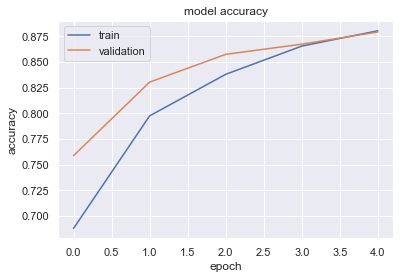

In [102]:
# Show history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

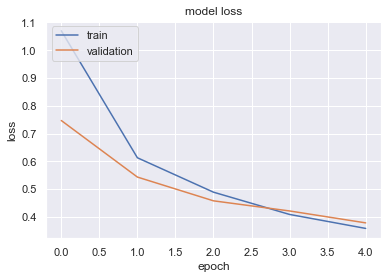

In [103]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Confusion matrix

In [19]:
# First let the model predict
y_pred = model.predict(x_test)

[Text(0, 0.5, 'yes'),
 Text(0, 1.5, 'no'),
 Text(0, 2.5, 'up'),
 Text(0, 3.5, 'down'),
 Text(0, 4.5, 'left'),
 Text(0, 5.5, 'right'),
 Text(0, 6.5, 'on'),
 Text(0, 7.5, 'off'),
 Text(0, 8.5, 'stop'),
 Text(0, 9.5, 'go'),
 Text(0, 10.5, 'unknown')]

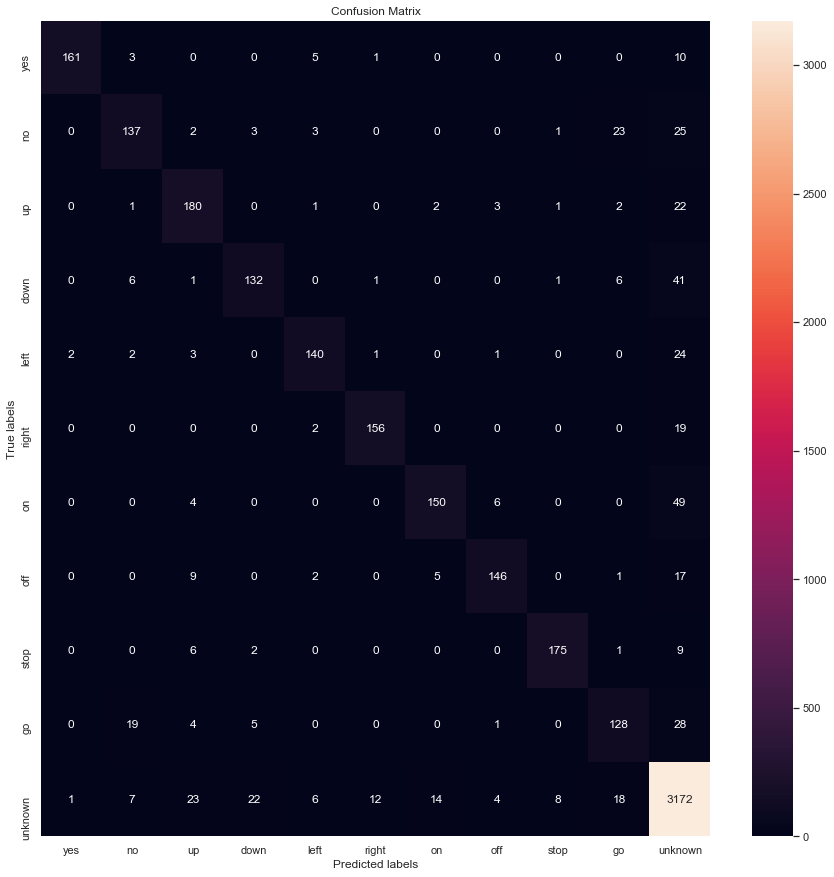

In [42]:
# Then calculate the confusion matrix based on predictions
y_test_cm = y_test.argmax(axis=1)
y_pred_cm = y_pred.argmax(axis=1)
cm = confusion_matrix(y_test_cm, y_pred_cm)

# Labels
perm_labels = helper_functions.PERMITTED_LABELS
try:
    perm_labels.remove('silence')
except:
    # do nothing
    False

fig_dim = 15
fig_size = (fig_dim, fig_dim)
fig, ax = plt.subplots(figsize=fig_size)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(perm_labels); ax.yaxis.set_ticklabels(perm_labels)

Average precision score, micro-averaged over all classes: 0.95


c:\users\aipel\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.95288')

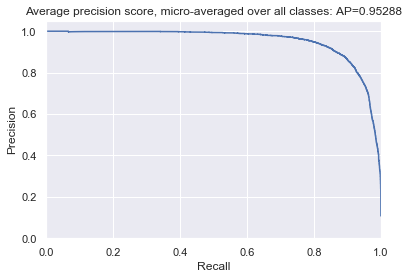

In [135]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision = dict()
recall = dict()
average_precision = dict()
for i in range(12):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test, y_pred,average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.5f}'
    .format(average_precision["micro"]))